In [19]:
import os
import random

directories = [
    "./data_emotion/Ahegao",
    "./data_emotion/Angry",
    "./data_emotion/Happy",
    "./data_emotion/Neutral",
    "./data_emotion/Sad",
    "./data_emotion/Surprise"
]

file_counts = {}
for directory in directories:
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    file_counts[directory] = files


min_count = min(len(files) for files in file_counts.values())
print(f"Minimum number of files to keep: {min_count}")

for directory, files in file_counts.items():
    if len(files) > min_count:
        files_to_delete = random.sample(files, len(files) - min_count)
        for f in files_to_delete:
            os.remove(os.path.join(directory, f))
        print(f"Deleted {len(files_to_delete)} files from {directory}")
    else:
        print(f"No deletion needed in {directory}")


Minimum number of files to keep: 1205
No deletion needed in ./data_emotion/Ahegao
Deleted 108 files from ./data_emotion/Angry
Deleted 2535 files from ./data_emotion/Happy
Deleted 2822 files from ./data_emotion/Neutral
Deleted 2729 files from ./data_emotion/Sad
Deleted 29 files from ./data_emotion/Surprise


> Importing Libraries 

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import  LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from PIL import Image
from xgboost import XGBClassifier
import plotly.express as px
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import optuna
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Exploration

In [2]:
df_emotion = pd.read_csv('./data_emotion/data (1).csv')
print(f"Dataset shape: {df_emotion.shape}")
print(f"Columns: {df_emotion.columns.tolist()}")

Dataset shape: (15453, 3)
Columns: ['Unnamed: 0', 'path', 'label']


- Visualizing data distribution

In [3]:
data=df_emotion.groupby('label')['path'].count().reset_index()
data=data.rename(columns={'path':'Count'})
fig=px.bar(data, x='label', y='Count',
             title="Emotion Distribution",color='label', template='plotly_dark')
fig.show()

## 2. Data Preprocessing

In [4]:
X = df_emotion.drop(['label','Unnamed: 0'], axis=1)
y = df_emotion['label']
def load_image_to_array(image_path, target_size=(48, 48)):
    try:
        img = Image.open('./data_emotion/' + image_path).convert('RGB')
        img = img.resize(target_size)
        return np.array(img)
    except Exception as e:
        return None
image_arrays = []
filtered_labels = []
for idx, path in enumerate(X.iloc[:, 0]):
    arr = load_image_to_array(path)
    if arr is not None:
        image_arrays.append(arr)
        filtered_labels.append(y.iloc[idx])  
X = np.array(image_arrays, dtype='float32') / 255.0
y = np.array(filtered_labels)



- Encode labels

In [5]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [6]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))
features_model = Model(inputs=vgg.input, outputs=vgg.output)


features = features_model.predict(X, batch_size=32, verbose=1)
features_flat = features.reshape(features.shape[0], -1)


226/226 ━━━━━━━━━━━━━━━━━━━━ 97s 426ms/step


- Split data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    features_flat, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [8]:


pca = PCA(n_components=500)  
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

## 3. Model Training and Evaluation

Trying KNN

In [9]:
knn=KNeighborsClassifier(n_neighbors=5,metric='minkowski')
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print('classificatioon report')
print(classification_report(y_pred,y_test))

classificatioon report
              precision    recall  f1-score   support

           0       0.72      0.62      0.67       282
           1       0.44      0.37      0.40       281
           2       0.46      0.38      0.42       292
           3       0.29      0.33      0.31       209
           4       0.24      0.31      0.27       186
           5       0.36      0.44      0.39       196

    accuracy                           0.42      1446
   macro avg       0.42      0.41      0.41      1446
weighted avg       0.44      0.42      0.43      1446



Trying GridSearch for hyperparameters Tuning 

In [10]:
param_grid = {
    'n_neighbors': [11,12,13],
    'weights': ['uniform', 'distance'],
    'metric':['euclidean','minkowski'],
    'p': [1, 2] 
}
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  
)
grid_search.fit(X_train, y_train)
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(grid_search.best_params_)
print(f"Test accuracy: {accuracy:.4f}")
print('classificatioon report')
print(classification_report(y_pred,y_test))

{'metric': 'euclidean', 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
Test accuracy: 0.4357
classificatioon report
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       248
           1       0.41      0.42      0.42       240
           2       0.44      0.39      0.41       268
           3       0.28      0.35      0.31       195
           4       0.34      0.31      0.32       264
           5       0.42      0.44      0.43       231

    accuracy                           0.44      1446
   macro avg       0.44      0.43      0.43      1446
weighted avg       0.44      0.44      0.44      1446



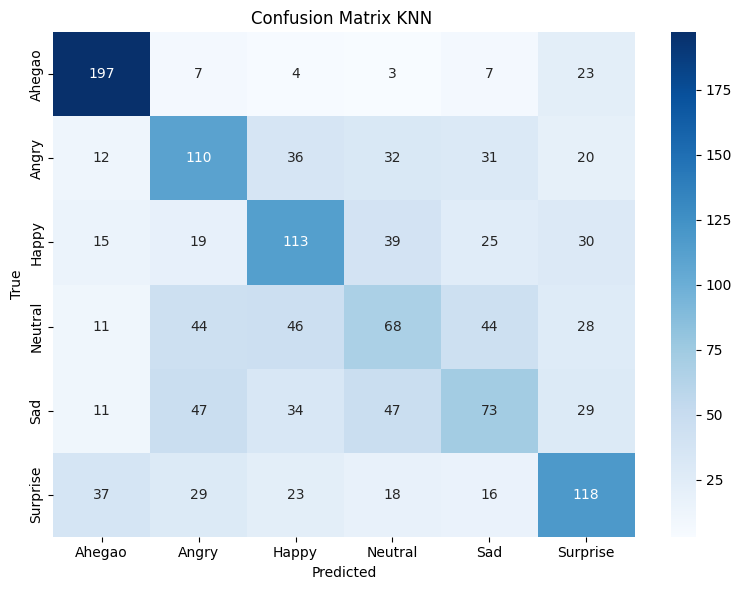

In [16]:

cm = confusion_matrix(y_test, y_pred)
labels = le.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix KNN ')
plt.tight_layout()
plt.show()

Trying XGBoost

In [11]:
xgb_clf = XGBClassifier(
    objective='multi:softmax',  
    num_class=len(np.unique(y_encoded)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1
)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.80      0.74       241
           1       0.45      0.42      0.44       241
           2       0.44      0.46      0.45       241
           3       0.36      0.34      0.35       241
           4       0.33      0.29      0.31       241
           5       0.49      0.51      0.50       241

    accuracy                           0.47      1446
   macro avg       0.46      0.47      0.46      1446
weighted avg       0.46      0.47      0.46      1446



Optuna for hyperparameters tuning for XGBoost

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300]),
        'max_depth': trial.suggest_categorical('max_depth', [4, 6, 8]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.1, 0.2]),
        'subsample': trial.suggest_categorical('subsample', [0.8, 1.0]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.8, 1.0]),
        'objective': 'multi:softmax',
        'num_class': len(set(y_train)),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42
    }

    clf = XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy  

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30,show_progress_bar=True)  



[I 2025-11-24 21:20:11,181] A new study created in memory with name: no-name-d3a6c9c3-5455-4690-af05-e8818caf25dc


Best trial: 0. Best value: 0.451591:   3%|▎         | 1/30 [00:46<22:22, 46.30s/it]

[I 2025-11-24 21:20:57,583] Trial 0 finished with value: 0.4515905947441217 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.2, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.4515905947441217.


Best trial: 0. Best value: 0.451591:   7%|▋         | 2/30 [01:29<20:46, 44.50s/it]

[I 2025-11-24 21:21:40,827] Trial 1 finished with value: 0.4515905947441217 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.2, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.4515905947441217.


Best trial: 2. Best value: 0.465422:  10%|█         | 3/30 [02:07<18:34, 41.29s/it]

[I 2025-11-24 21:22:18,305] Trial 2 finished with value: 0.4654218533886584 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.2, 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 2 with value: 0.4654218533886584.


Best trial: 3. Best value: 0.479945:  13%|█▎        | 4/30 [06:43<58:08, 134.18s/it]

[I 2025-11-24 21:26:54,796] Trial 3 finished with value: 0.47994467496542187 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.2, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 3 with value: 0.47994467496542187.


Best trial: 3. Best value: 0.479945:  17%|█▋        | 5/30 [13:05<1:33:05, 223.42s/it]

[I 2025-11-24 21:33:16,416] Trial 4 finished with value: 0.46680497925311204 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 3 with value: 0.47994467496542187.


Best trial: 3. Best value: 0.479945:  20%|██        | 6/30 [17:15<1:33:03, 232.65s/it]

[I 2025-11-24 21:37:27,040] Trial 5 finished with value: 0.4343015214384509 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.01, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 3 with value: 0.47994467496542187.


Best trial: 3. Best value: 0.479945:  23%|██▎       | 7/30 [20:53<1:27:17, 227.72s/it]

[I 2025-11-24 21:41:04,608] Trial 6 finished with value: 0.475103734439834 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.2, 'subsample': 0.8, 'colsample_bytree': 0.8}. Best is trial 3 with value: 0.47994467496542187.


Best trial: 3. Best value: 0.479945:  27%|██▋       | 8/30 [23:35<1:15:52, 206.94s/it]

[I 2025-11-24 21:43:47,123] Trial 7 finished with value: 0.4778699861687414 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.2, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 3 with value: 0.47994467496542187.


Best trial: 3. Best value: 0.479945:  30%|███       | 9/30 [26:42<1:10:15, 200.72s/it]

[I 2025-11-24 21:46:54,081] Trial 8 finished with value: 0.46957123098201936 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 3 with value: 0.47994467496542187.


Best trial: 9. Best value: 0.482711:  33%|███▎      | 10/30 [32:51<1:24:12, 252.62s/it]

[I 2025-11-24 21:53:02,948] Trial 9 finished with value: 0.4827109266943292 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 9 with value: 0.4827109266943292.


Best trial: 9. Best value: 0.482711:  37%|███▋      | 11/30 [35:33<1:11:11, 224.82s/it]

[I 2025-11-24 21:55:44,788] Trial 10 finished with value: 0.4633471645919779 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 9 with value: 0.4827109266943292.


Best trial: 9. Best value: 0.482711:  40%|████      | 12/30 [44:57<1:38:22, 327.94s/it]

[I 2025-11-24 22:05:08,504] Trial 11 finished with value: 0.4536652835408022 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.01, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 9 with value: 0.4827109266943292.


Best trial: 9. Best value: 0.482711:  43%|████▎     | 13/30 [49:19<1:27:18, 308.15s/it]

[I 2025-11-24 22:09:31,168] Trial 12 finished with value: 0.4827109266943292 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 9 with value: 0.4827109266943292.


Best trial: 9. Best value: 0.482711:  47%|████▋     | 14/30 [53:46<1:18:47, 295.49s/it]

[I 2025-11-24 22:13:57,383] Trial 13 finished with value: 0.4827109266943292 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 9 with value: 0.4827109266943292.


Best trial: 9. Best value: 0.482711:  50%|█████     | 15/30 [58:21<1:12:21, 289.43s/it]

[I 2025-11-24 22:18:32,829] Trial 14 finished with value: 0.4778699861687414 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 1.0}. Best is trial 9 with value: 0.4827109266943292.


Best trial: 9. Best value: 0.482711:  53%|█████▎    | 16/30 [1:01:21<59:50, 256.46s/it]  

[I 2025-11-24 22:21:32,717] Trial 15 finished with value: 0.47372060857538034 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 9 with value: 0.4827109266943292.


Best trial: 9. Best value: 0.482711:  57%|█████▋    | 17/30 [1:05:41<55:48, 257.57s/it]

[I 2025-11-24 22:25:52,822] Trial 16 finished with value: 0.4827109266943292 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 9 with value: 0.4827109266943292.


Best trial: 9. Best value: 0.482711:  60%|██████    | 18/30 [1:09:14<48:48, 244.08s/it]

[I 2025-11-24 22:29:25,489] Trial 17 finished with value: 0.4785615491009682 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8}. Best is trial 9 with value: 0.4827109266943292.


Best trial: 9. Best value: 0.482711:  63%|██████▎   | 19/30 [1:11:01<37:13, 203.01s/it]

[I 2025-11-24 22:31:12,894] Trial 18 finished with value: 0.43291839557399725 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.01, 'subsample': 0.8, 'colsample_bytree': 1.0}. Best is trial 9 with value: 0.4827109266943292.


In [13]:


best_xgb = XGBClassifier(
    **{'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8},
    objective='multi:softmax',
    num_class=len(set(y_train)),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
best_xgb.fit(X_train, y_train)

y_pred = best_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.4696
Classification report:
              precision    recall  f1-score   support

           0       0.70      0.82      0.75       241
           1       0.43      0.46      0.44       241
           2       0.44      0.47      0.45       241
           3       0.33      0.28      0.30       241
           4       0.37      0.30      0.33       241
           5       0.48      0.49      0.48       241

    accuracy                           0.47      1446
   macro avg       0.46      0.47      0.46      1446
weighted avg       0.46      0.47      0.46      1446



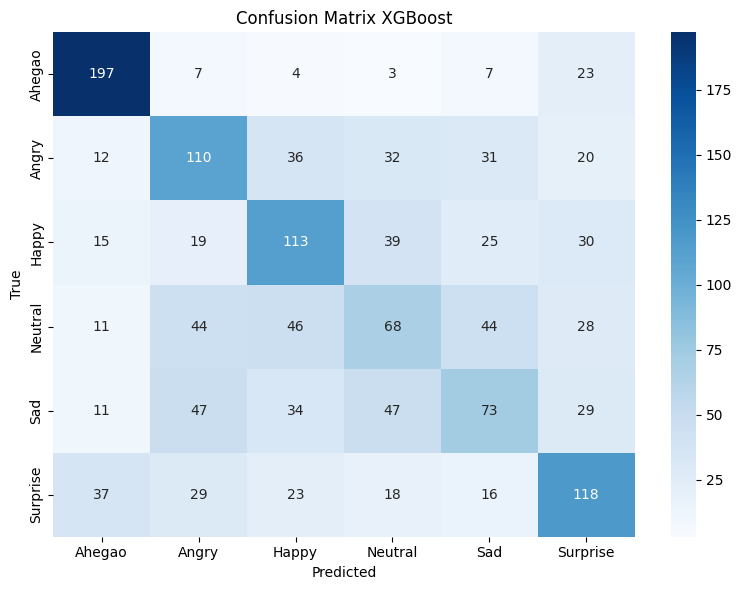

In [17]:

cm = confusion_matrix(y_test, y_pred)
labels = le.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix XGBoost')
plt.tight_layout()
plt.show()